<a href="https://colab.research.google.com/github/buoi/conditional-face-GAN/blob/main/attribute_conditional_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attribute Conditional Face Generation with GANs

Marco Buiani  
Matteo Folli

# ⚙️ Setup

## Fix random seeds

In [1]:
SEED = 11
import os
os.environ['PYTHONHASHSEED']=str(SEED)
import random
import numpy as np
import tensorflow as tf

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Automatic Mixed Precision
if supported by GPU

In [2]:
_, gpu_name  = !nvidia-smi --query-gpu=gpu_name --format=csv

if gpu_name == 'Tesla T4':
    from tensorflow.keras import mixed_precision

    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9ed3519e-ab2f-d305-0516-52058430afb1)


## Imports

In [3]:
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.layers import Layer, Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, Add, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, UpSampling2D, BatchNormalization
import tensorflow.keras.backend as K

from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization

import gdown
from zipfile import ZipFile

from tqdm.notebook import tqdm

## Download CelebA

We'll use face images from the CelebA dataset, resized to 64x64.

In [4]:
try:
    os.makedirs("celeba_gan")
    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "celeba_gan/img_align_celeba.zip"
    gdown.download(url, output, quiet=True)

    with ZipFile("celeba_gan/img_align_celeba.zip", "r") as zipobj:
        zipobj.extractall("celeba_gan")
        
except FileExistsError:
    print("Dataset Already downloaded")


Dataset Already downloaded


In [5]:
#Download labels from public github, they have been processed in a 0,1 csv file
!wget -q -O "/content/celeba_gan/list_attr_celeba01.csv.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba01.csv.zip?raw=true" 
!unzip -o "/content/celeba_gan/list_attr_celeba01.csv.zip" -d "/content/celeba_gan"

Archive:  /content/celeba_gan/list_attr_celeba01.csv.zip
  inflating: /content/celeba_gan/list_attr_celeba01.csv  
  inflating: /content/celeba_gan/__MACOSX/._list_attr_celeba01.csv  


## Dataset preprocessing functions

In [6]:
# image utils functions

def conv_range(in_range=(-1,1), out_range=(0,255)):
    """ Returns range conversion function"""

    # compute means and spans once
    in_mean, out_mean = np.mean(in_range), np.mean(out_range)
    in_span, out_span = np.ptp(in_range), np.ptp(out_range)

    # return function
    def convert_img_range(in_img):
        out_img = (in_img - in_mean) / in_span
        out_img = out_img * out_span + out_mean
        return out_img

    return convert_img_range

def crop128(img):
    #return img[:, 77:141, 57:121]# 64,64 center crop
    return img[:, 45:173, 25:153] # 128,128 center crop

def resize64(img):
    return tf.image.resize(img, (64,64), antialias=True, method='bilinear')

# 💾  Build Dataset 
create Dataset object from our folder, and rescale the images to the [-1,1] range:

Found 202599 files belonging to 2 classes.
image in range:  -1.0 1.0000004


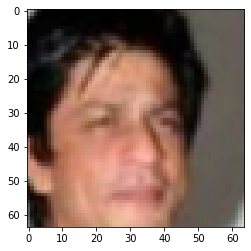

In [8]:
#@title Select Attributes {form-width: "50%", display-mode: "form" }

NUMBER_OF_ATTRIBUTES = "0" #@param [0, 2, 10, 40]
N_ATTRIBUTES = int(NUMBER_OF_ATTRIBUTES)

IMAGE_SHAPE = '64x64x3' #@param ['64x64x3', '218x178x3']
IMAGE_SHAPE = tuple(int(n) for n in IMAGE_SHAPE.split('x'))
IMAGE_SIZE = IMAGE_SHAPE[0]

BATCH_SIZE =  64 #@param {type: "number"}

IMAGE_RANGE = '11'

if N_ATTRIBUTES == 2:
    LABELS = ["Male", "Smiling"]

elif N_ATTRIBUTES == 10:
    LABELS = [
          "Mouth_Slightly_Open", "Wearing_Lipstick", "High_Cheekbones", "Male", "Smiling", 
          "Heavy_Makeup", "Wavy_Hair", "Oval_Face", "Pointy_Nose", "Arched_Eyebrows"]

elif N_ATTRIBUTES == 40:
    LABELS = [
            '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
            'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
            'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
            'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
            'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
            'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
            'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
            'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

else:
    LABELS = ["Male", "Smiling"]# just for dataset creation
 

# Take labels and a list of image locations in memory
df = pd.read_csv(r"/content/celeba_gan/list_attr_celeba01.csv")
im_list = df['image_id'].tolist()


# load image at exact resolution
dataset_train = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode="int", 
    labels = df[LABELS].values.tolist(),
    image_size=(218, 178), 
    batch_size=BATCH_SIZE,
    seed=SEED)


def preprocess(dataset):
    # extract the center crop
    if IMAGE_SIZE == 64:
        dataset = dataset.map(lambda x,y: (crop128(x),y) )
        # resize
        dataset = dataset.map(lambda x,y: (resize64(x),y) )
    # convert image range
    dataset = dataset.map(lambda x,y: (conv_range([0,255], [-1,1])(x),y) )
    return dataset

dataset_train = preprocess(dataset_train)

if N_ATTRIBUTES !=0: 
    batch_img, batch_labels = next(iter(dataset_train))
    plt.title('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*int(label) for i,label in enumerate(batch_labels[0])]))

else: # remove labels
    dataset_train = dataset_train.map(lambda x,y: x)
    batch_img = next(iter(dataset_train))
    
plt.imshow(batch_img[0].numpy()/2+0.5)

print("image in range: ", np.min(batch_img), np.max(batch_img))

In [9]:
if N_ATTRIBUTES !=0:
    attribute_cumsums = np.sum(df[LABELS].values, axis=0)

    attribute_frequency = attribute_cumsums/df[LABELS].values.shape[0]
    # shows how much each attribute deviates from being 50%
    freq_sorted, labels_sorted  = zip(*sorted(zip(attribute_frequency, LABELS)))
    freq_sorted = np.array(freq_sorted)

    plt.figure(figsize=(8,10))
    plt.yticks(np.arange(N_ATTRIBUTES),labels=labels_sorted, fontsize=10)
    plt.axvline(x=0.5)
    plt.barh(np.arange(N_ATTRIBUTES), freq_sorted);

# 🕵🏻‍♂️👩🏼‍🎨 Model

## Custom Layers

### Spectral Normalization

In [10]:
from tensorflow_addons.layers import SpectralNormalization

### Self Attention

In [11]:
from keras.layers import InputSpec
import keras.backend as K

class SelfAttention(Layer):

    def __init__(self, ch, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f',
                                        trainable=True)
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g',
                                        trainable=True)
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h',
                                        trainable=True)

        super(SelfAttention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True

    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[3]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]

        s = K.batch_dot(hw_flatten(g), K.permute_dimensions(hw_flatten(f), (0, 2, 1)))  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape

### Minibatch Standard Deviation

In [12]:
# mini-batch standard deviation layer
class MinibatchStdev(layers.Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # calculate the mean standard deviation across each pixel coord
    def call(self, inputs):
        mean = K.mean(inputs, axis=0, keepdims=True)
        mean_sq_diff = K.mean(K.square(inputs - mean), axis=0, keepdims=True) + 1e-8
        mean_pix = K.mean(K.sqrt(mean_sq_diff), keepdims=True)
        shape = K.shape(inputs)
        output = K.tile(mean_pix, [shape[0], shape[1], shape[2], 1])
        return K.concatenate([inputs, output], axis=-1)

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

In [13]:
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = tf.keras.backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = tf.keras.backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = tf.keras.backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = tf.keras.backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = tf.keras.backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = tf.keras.backend.shape(inputs)
        output = tf.keras.backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = tf.keras.backend.concatenate([inputs, output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

In [14]:
class PixelNormalization(Layer):
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)
        self.epsilon= 1e-8

    def call(self, inputs):

        #return inputs * tf.math.rsqrt(tf.reduce_mean(tf.math.square(inputs), axis=1, keepdims=True) + self.epsilon)
        # Calculate square pixel values
        values = inputs**2.0
        # Calculate the mean pixel values
        mean_values = tf.keras.backend.mean(values, axis=-1, keepdims=True)
        # Ensure the mean is not zero
        mean_values += 1.0e-8
        # Calculate the sqrt of the mean squared value (L2 norm)
        l2 = tf.keras.backend.sqrt(mean_values)
        # Normalize values by the l2 norm
        normalized = inputs / l2
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape
    

## Define Building Functions

### BN stddev 218x178

In [15]:
# revisited
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
def define_generator218(latent_dim = 100, n_attributes=N_ATTRIBUTES):
#
    """
    carpedm20's generator is quasi-identical to soumith's
    except at the 1st layer: carpedm20's was easier, just
    a fully connected layer and a reshape.
    """

    n_channels_large = 128
    #n_channels_large = 64
    z = keras.Input(shape=(latent_dim,))


    #z_attr = layers.Concatenate(axis=-1)([z, tf.cast(in_attr, dtype='float32')])

    first_plane_shape = (7, 6, n_channels_large*8)

    gen_img = layers.Dense(np.prod(first_plane_shape),
                          kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(z)

    gen_img = layers.Reshape(first_plane_shape)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    #  attr input, dense,       reshape\
    #latent input, dense, relu, reshape/ concat, conv, BN
    if N_ATTRIBUTES !=0:
        in_attr = layers.Input(shape=(n_attributes))
        # attr -> 4*4
        attr_n_maps = {2:1, 10:1, 40:3}[N_ATTRIBUTES]
        attr_map = layers.Dense(np.prod(first_plane_shape[0]* first_plane_shape[1]*attr_n_maps),
                        kernel_initializer=RandomNormal(stddev=0.02,),
                        bias_initializer='zeros',)(in_attr)
                        
        attr_map = layers.Reshape((first_plane_shape[0], first_plane_shape[1], attr_n_maps))(attr_map)
        attr_map = layers.Activation('relu')(attr_map)


        #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)    epsilon=1e-5, scale=True)(gen_img)

        #(None, 4,4, 1024) (None, 4,4,1)
        gen_img = layers.Concatenate()((gen_img, attr_map))


    # plane shape: (8,8,128*4)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*4, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)

    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (16,16,128*2)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*2, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    ###gen_img = SelfAttention(n_channels_large*2)(gen_img)



    # plane shape: (32,32,128)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    gen_img = tf.keras.layers.Cropping2D((0,1))(gen_img)


    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (64,64,3)
    gen_img = Conv2DTranspose(filters=3, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same')(gen_img)
    
    gen_img = tf.keras.layers.Cropping2D((3,3))(gen_img)

    gen_img = layers.Activation(activation='tanh', dtype='float32')(gen_img)

    if N_ATTRIBUTES !=0:
        generator = keras.Model(inputs= [z, in_attr], outputs=gen_img, name='cond_gen')
    else:
        generator = keras.Model(inputs=z, outputs=gen_img, name='gen')
    return generator
    return generator

def define_discriminator218(n_attributes=N_ATTRIBUTES):
    """
    carpedm20's discriminator is quasi-identical to soumith's
    except at the 1st layer: carpedm20's was easier, just
    the final layer being diff.
    """

    ndf = 128  # ndf or NDF: Number of Discriminator Filters

    input_img = layers.Input(shape=(218,178,3))

    #layers.RandomFlip(mode='horizontal')(input_img)

    # plane shape: (32,32,ndf)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(input_img)

    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*2, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (16,16,ndf*2)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*2, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    ##d_output_proba = SelfAttention(ndf*2)(d_output_proba)

    # plane shape: (8,8,ndf*4)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*4, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)
    

    # plane shape: (4,4,ndf*8)
    d_output_proba = Conv2D(filters=ndf*8, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same')(d_output_proba)
                      

    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    #
    d_output_proba = MinibatchStdev()(d_output_proba)
    #
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    """ Canceled and replaced by what follows it.
    # plane shape: (1,1,1)
    d_output_proba = layers.Conv2D(filters=1, kernel_size=5,
                                  strides=1, padding='valid',
                                  activation='sigmoid')(d_output_proba)
    d_output_proba = layers.Reshape((1,))(d_output_proba)
    """

    # Flatten and Dense to (None, 1) \in [0, 1].
    d_output_proba = layers.Flatten()(d_output_proba)

    out_realfake = layers.Dense(1,kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(d_output_proba)

    out_realfake = layers.Activation('sigmoid', name='sigmoid_realfake', dtype='float32')(out_realfake)

    if N_ATTRIBUTES !=0:
        out_attr = layers.Dense(n_attributes, dtype='float32')(d_output_proba)
        out_attr = layers.Activation('sigmoid', name='sigmoid_label', dtype='float32')(out_attr)
        discriminator = keras.Model(inputs=input_img, outputs=[out_realfake, out_attr], name='cond_discr')
    else:
        discriminator = keras.Model(inputs=input_img, outputs=out_realfake, name='discr')

    return discriminator



define_generator218().summary()
define_discriminator218().summary()


Model: "gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 43008)             4343808   
_________________________________________________________________
reshape (Reshape)            (None, 7, 6, 1024)        0         
_________________________________________________________________
activation_94 (Activation)   (None, 7, 6, 1024)        0         
_________________________________________________________________
spectral_normalization (Spec (None, 14, 12, 512)       13108736  
_________________________________________________________________
batch_normalization_94 (Batc (None, 14, 12, 512)       2048      
_________________________________________________________________
activation_95 (Activation)   (None, 14, 12, 512)       0       

### BN stddev 64x64

In [16]:
# revisited
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
def define_generator64(latent_dim = 100, n_attributes=N_ATTRIBUTES):
#
    """
    carpedm20's generator is quasi-identical to soumith's
    except at the 1st layer: carpedm20's was easier, just
    a fully connected layer and a reshape.
    """

    n_channels_large = 128
    #n_channels_large = 64

    z = keras.Input(shape=(latent_dim,))

    #z_attr = layers.Concatenate(axis=-1)([z, tf.cast(in_attr, dtype='float32')])

    first_plane_shape = (4, 4, n_channels_large*8)

    gen_img = layers.Dense(np.prod(first_plane_shape),
                          kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(z)

    gen_img = layers.Reshape(first_plane_shape)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    #  attr input, dense,       reshape\
    #latent input, dense, relu, reshape/ concat, conv, BN
    
    if N_ATTRIBUTES !=0:
        in_attr = layers.Input(shape=(n_attributes))
        # attr -> 4*4
        attr_n_maps = {2:1, 10:1, 40:3}[N_ATTRIBUTES]
        attr_map = layers.Dense(np.prod(first_plane_shape[0]* first_plane_shape[1]*attr_n_maps),
                        kernel_initializer=RandomNormal(stddev=0.02,),
                        bias_initializer='zeros',)(in_attr)
                        
        attr_map = layers.Reshape((first_plane_shape[0], first_plane_shape[1], attr_n_maps))(attr_map)
        attr_map = layers.Activation('relu')(attr_map)


        #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)    epsilon=1e-5, scale=True)(gen_img)

        #(None, 4,4, 1024) (None, 4,4,1)
        gen_img = layers.Concatenate()((gen_img, attr_map))


    # plane shape: (8,8,128*4)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*4, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)

    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (16,16,128*2)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*2, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    ###gen_img = SelfAttention(n_channels_large*2)(gen_img)



    # plane shape: (32,32,128)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    #gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)



    # plane shape: (64,64,3)
    gen_img = Conv2DTranspose(filters=3, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same')(gen_img)

    gen_img = layers.Activation(activation='tanh', dtype='float32')(gen_img)

    if N_ATTRIBUTES !=0:
        generator = keras.Model(inputs= [z, in_attr], outputs=gen_img, name='cond_gen')
    else:
        generator = keras.Model(inputs=z, outputs=gen_img, name='gen')
    return generator

def define_discriminator64(n_attributes=N_ATTRIBUTES):
    """
    carpedm20's discriminator is quasi-identical to soumith's
    except at the 1st layer: carpedm20's was easier, just
    the final layer being diff.
    """

    ndf = 128  # ndf or NDF: Number of Discriminator Filters

    input_img = layers.Input(shape=(64,64,3))

    #layers.RandomFlip(mode='horizontal')(input_img)

    # plane shape: (32,32,ndf)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(input_img)

    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)


    # plane shape: (16,16,ndf*2)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*2, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    ##d_output_proba = SelfAttention(ndf*2)(d_output_proba)

    # plane shape: (8,8,ndf*4)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*4, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (4,4,ndf*8)
    d_output_proba = Conv2D(filters=ndf*8, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same')(d_output_proba)

    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    #
    d_output_proba = MinibatchStdev()(d_output_proba)
    #
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    """ Canceled and replaced by what follows it.
    # plane shape: (1,1,1)
    d_output_proba = layers.Conv2D(filters=1, kernel_size=5,
                                  strides=1, padding='valid',
                                  activation='sigmoid')(d_output_proba)
    d_output_proba = layers.Reshape((1,))(d_output_proba)
    """

    # Flatten and Dense to (None, 1) \in [0, 1].
    d_output_proba = layers.Flatten()(d_output_proba)
    #d_output_proba = GlobalAveragePooling2D()(d_output_proba)


    out_realfake = layers.Dense(1,kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(d_output_proba)

    out_realfake = layers.Activation('sigmoid', name='sigmoid_realfake', dtype='float32')(out_realfake)

    if N_ATTRIBUTES !=0:
        out_attr = layers.Dense(n_attributes, dtype='float32')(d_output_proba)
        out_attr = layers.Activation('sigmoid', name='sigmoid_label', dtype='float32')(out_attr)
        discriminator = keras.Model(inputs=input_img, outputs=[out_realfake, out_attr], name='cond_discr')
    else:
        discriminator = keras.Model(inputs=input_img, outputs=out_realfake, name='discr')

    return discriminator


define_generator64().summary()
define_discriminator64().summary()


Model: "gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
activation_100 (Activation)  (None, 4, 4, 1024)        0         
_________________________________________________________________
spectral_normalization_8 (Sp (None, 8, 8, 512)         13108736  
_________________________________________________________________
batch_normalization_102 (Bat (None, 8, 8, 512)         2048      
_________________________________________________________________
activation_101 (Activation)  (None, 8, 8, 512)         0       

## Define GAN Class
override `train_step`

### AC-GAN

In [17]:
class ACGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, n_attributes, **kwargs):
        super(ACGAN, self).__init__(**kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.n_attributes = n_attributes# deprecated, take from data

    def compile(self, d_optimizer, g_optimizer, loss_fn, loss_attr):
        super(ACGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

        self.d_realfake_metric = keras.metrics.Mean(name="d_realfake")
        self.d_attr_metric = keras.metrics.Mean(name="d_attr")

        self.g_realfake_metric = keras.metrics.Mean(name="g_realfake")
        self.g_attr_metric = keras.metrics.Mean(name="g_attr")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        real_images, real_attr = data 
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        #n_attributes = real_attr.shape[-1]###### 
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        #random_attr = tf.random.uniform(shape=(batch_size, self.n_attributes), maxval=2, dtype='int64')

        # Decode them to fake images
        #generated_images = self.generator([random_latent_vectors, random_attr])
        # using same real_attr instead of random sampled ones.. is this safe? #########
        generated_images = self.generator([random_latent_vectors, real_attr])

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating fake(1) from real(0) images

        labels_fake = tf.ones((batch_size, 1)) - 0.05 * tf.random.uniform((batch_size, 1))
        labels_real = tf.zeros((batch_size, 1)) + 0.05 * tf.random.uniform((batch_size, 1))

        labels_realfake = tf.concat([labels_fake, labels_real], axis=0)

        """labels_realfake = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        labels_realfake = labels_realfake + 0.05 * tf.random.uniform(tf.shape(labels_realfake))
        """
        #labels_attr = tf.concat([random_attr, real_attr], axis=0)
        # NON HA SENSO LA LOSS SULLA SECONDA PARTE... OPPURE VA INVERTITA IN BASSO

        labels_attr = tf.concat([real_attr, real_attr], axis=0) #????
        labels_attr = tf.cast(labels_attr, dtype='float32')

        # Add random noise to the labels - important trick!
        #labels_attr = labels_attr + 0.05 * tf.random.uniform(tf.shape(labels_attr))

        # Train the discriminator
        with tf.GradientTape() as tape:
            pred_realfake, pred_attr = self.discriminator(combined_images)
            pred_real_attr = pred_attr[batch_size: 2*batch_size]

            d_loss_realfake = self.loss_fn(labels_realfake, pred_realfake)
            #print(f"loss_fn({labels_realfake}, {pred_realfake})")
            #print('= ',d_loss_realfake)

            d_loss_attr = self.loss_fn(real_attr, pred_real_attr)#######-1tf.reduce_mean(
            #print(f"loss_fn({labels_attr}, {pred_attr})")
            #print('= ',self.loss_fn(labels_attr, pred_attr))
            #print('reduce_mean -> ',d_loss_attr)

            #print(f"d_loss_realfake: {d_loss_realfake} + d_loss_attr: {d_loss_attr}")
            d_loss = d_loss_realfake + d_loss_attr 
      
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        ## GEN,
        # Sample 2*batch_size so Gen sees the same number of images as Disc

        # Sample NEW random points in the latent space (D has just optimized for previous ones)
        random_latent_vectors = tf.random.normal(shape=(2*batch_size, self.latent_dim))
        # [2*16, 128], [16,2]
        #random_attr = tf.random.uniform(shape=(batch_size, self.n_attributes), maxval=2, dtype='int64')

        # using sampled real attributes during entire training step
        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((2*batch_size, 1)) # same as inverting loss sign?

        ##### SHOULD WE SWITCH ATTRIBUTES?!

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            pred_realfake, pred_attr = self.discriminator(
                self.generator([random_latent_vectors, labels_attr]))
            
            g_loss_realfake = self.loss_fn(misleading_labels, pred_realfake)

            #print(f"loss_fn({misleading_labels}, {pred_realfake})")
            #print('= ',g_loss_realfake)

            g_loss_attr = self.loss_fn(labels_attr, pred_attr) ##########tf.reduce_mean(
            #print(f"loss_fn({random_attr}, {pred_attr})")
            #print('= ',self.loss_fn(real_attr, pred_attr))
            #print('reduce_mean -> ',g_loss_attr)

            #print(f"g_loss_realfake: {g_loss_realfake} + g_loss_attr: {g_loss_attr}")
            g_loss = g_loss_realfake + g_loss_attr

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        self.d_realfake_metric.update_state(d_loss_realfake)
        self.d_attr_metric.update_state(d_loss_attr)

        self.g_realfake_metric.update_state(g_loss_realfake)
        self.g_attr_metric.update_state(g_loss_attr)
       
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),

            "d_loss_realfake": self.d_realfake_metric.result(),
            "d_loss_attr": self.d_attr_metric.result(),
            "g_loss_realfake": self.g_realfake_metric.result(),
            "g_loss_attr": self.g_attr_metric.result()

        }


    def call(self, inputs):
        latent, label = inputs
        generated_images = self.generator([latent, label])
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss


### GAN

In [18]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        generator_gain = 2
        random_latent_vectors = tf.random.normal(shape=(generator_gain*batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((generator_gain*batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def call(self, inputs):
        
        generated_images = self.generator(inputs)
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss


In [19]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}
        
    def call(self, inputs):
      
        generated_images = self.generator(inputs)
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss

# 📉 Training callbacks

### Images logger

In [20]:
class ImagesLogger(keras.callbacks.Callback):
    def __init__(self, num_img=8, latent_dim=128, **kwargs):
        super(ImagesLogger, self).__init__(**kwargs)
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))


        if N_ATTRIBUTES !=0:
            random_attr = np.array([df[LABELS].values[i] for i in np.random.randint(0,202600, self.num_img)])
            generated_images = self.model.generator((random_latent_vectors, random_attr))
        else:
            generated_images = self.model.generator(random_latent_vectors)

        generated_images.numpy()
        if IMAGE_RANGE == '11':
            generated_images = conv_range((-1,1), (0,1))(generated_images)

        if ENABLE_WANDB:
            log_images = [wandb.Image(img) for img in generated_images]
            #log_name = f"Epoch {str(epoch)+str(LABELS)+str(random_attr.numpy())}"
            wandb.log({f"Epoch {epoch}": (log_images)})

        fig, axes = plt.subplots(1, self.num_img, figsize=(30,30))
        
        for i, axis in enumerate(axes):
            axis.axis('off')
            if N_ATTRIBUTES !=0:
                axis.title.set_text('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*label for i,label in enumerate(random_attr[i])]))
            axis.imshow(generated_images[i])
        plt.show()
 
    """def on_batch_end(self, batch, logs=None):

        freq = 200
        if (batch+1) % freq == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            random_attr = tf.random.uniform(shape=(self.num_img, N_ATTRIBUTES), maxval=2, dtype='int64')

            generated_images = self.model.generator((random_latent_vectors, random_attr))
            generated_images.numpy()


            fig, axes = plt.subplots(1, self.num_img, figsize=(30,30))
            for i, axis in enumerate(axes):
                axis.axis('off')
                axis.title.set_text(f"{[LABELS[label] for label in random_attr[i]]}")
                if IMAGE_RANGE == '11':
                    axis.imshow(generated_images[i]/2+0.5)
                else:
                    axis.imshow(generated_images[i])

            fig.set_facecolor((56/255,56/255,56/255))
            plt.show()""";

### Model logger

In [21]:
# log checkpoint artifacts to wandb

SAVE_PATH = 'models/'
os.makedirs(SAVE_PATH, exist_ok=True)

class ModelLogger(keras.callbacks.Callback):
    def __init__(self, model_name, run):
        super(ModelLogger, self).__init__()
        assert ENABLE_WANDB == True
        self.model_name = model_name
        self.run = run
        
    def on_epoch_end(self, epoch, logs=None):

        self.model.save(SAVE_PATH + self.model_name, save_format='tf')
        self.artifact = wandb.Artifact(self.model_name, type='model')
        self.artifact.add_dir(SAVE_PATH)
        self.run.log_artifact(self.artifact)


### FID Logger

In [23]:
#@title Load Multilabel Classifier Model{form-width: "35%", display-mode: "both" }

#refactor to attribute accuracy logger
ENABLE_LOAD = True #@param {type:"boolean"}
import tensorflow.keras.backend as K


def f1_metric_logits(y_true, y_pred):
    y_pred = K.round(keras.activations.sigmoid(y_pred))
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def weighted_bce_from_logits(y_true, y_pred):

    #inverted_frequency weighting
    pos_weight= (1-attribute_frequency)*2
    y_true = tf.cast(y_true,'float32')
    bce = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=pos_weight)
    #weighted_bce = attribute_frequency*(1-y_true) *bce
    #print(bce, weighted_bce)
    return K.mean(bce,axis=-1)


custom_objects = {'f1_metric': f1_metric, 
                  'f1_metric_logits': f1_metric_logits,
                  'weighted_bce_from_logits': weighted_bce_from_logits}

if IMAGE_SIZE == 64:
    if N_ATTRIBUTES == 2:
        resume_id = "    '2ckbukxu'"
        model_name = experiment_name = "mobilenet_2attr_weighted"

    elif N_ATTRIBUTES == 10:
        resume_id = "1ciqd5nw"
        model_name = experiment_name = "mobilenet_10attr_weighted"

    elif N_ATTRIBUTES == 40:
        resume_id = "123ijj97"
        model_name = experiment_name = "mobilenet_40attr_weighted"

    else:
        print("N_ATTRIBUTES=", N_ATTRIBUTES, "skipping classifier load")
        ENABLE_LOAD = False
elif IMAGE_SIZE == 218:
    if N_ATTRIBUTES == 2:
        resume_id = '3b15ld8p'
        model_name = experiment_name = "mobilenet_2attr_218x178_weighted"

    elif N_ATTRIBUTES == 10:
        resume_id = "3n56eda3"
        model_name = experiment_name = "mobilenet_10attr_218x178_weighted"
    
    elif N_ATTRIBUTES == 40:
        resume_id = "zd9xh3kq"
        model_name = experiment_name = "mobilenet_40attr_218x178_weighted"
   
    else:
        print("N_ATTRIBUTES=", N_ATTRIBUTES, "skipping classifier load")
        ENABLE_LOAD = False


if ENABLE_LOAD:
    project_name = "GAN"
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, 
                     name=experiment_name, 
                     resume=resume_id)

    run_name = 'buio/GAN/'+ model_name
    artifact_run = run_name +':latest'

    artifact = run.use_artifact(artifact_run, type='model')
    artifact_dir = artifact.download()
    attribute_classifier = tf.keras.models.load_model(os.path.join(artifact_dir, model_name),
                                                      custom_objects=custom_objects)

    attribute_classifier.compile(loss=keras.losses.BinaryCrossentropy(), metrics='binary_accuracy')
    #loss, gen_attr_accuracy = attribute_classifier.evaluate(dataset_df)
    #gen_attr_accuracy

    run.finish()


N_ATTRIBUTES= 0 skipping classifier load


In [24]:
FID_COUNT = 10000
class FIDLogger(keras.callbacks.Callback):
    def __init__(self, real_embeddings, real_attr=None):
        super(FIDLogger, self).__init__()
        self.real_embeddings = real_embeddings
        self.real_attr = real_attr

    def on_epoch_end(self, epoch, logs=None): # end

        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

        if N_ATTRIBUTES !=0:
            multi_evaluator = define_evaluator(self.model.generator, attribute_classifier)
        else:
            multi_evaluator = define_evaluator(self.model.generator)

        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)
        
        gen_size = 100
        assert FID_COUNT % gen_size == 0

        generated_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')

        if N_ATTRIBUTES !=0:
            pred_attr = np.zeros((FID_COUNT, N_ATTRIBUTES), dtype='float32')

            for i in tqdm(range(FID_COUNT//gen_size)):
              
                batch_embeddings, batch_attr = multi_evaluator((
                    tf.random.normal([gen_size, LATENT_DIM]),
                    self.real_attr[i*gen_size:(i+1)*gen_size]))
                
                generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings
                pred_attr[i*gen_size:(i+1)*gen_size] = batch_attr

            acc = np.mean(tf.keras.metrics.binary_accuracy(self.real_attr, pred_attr))
            f1_score = f1_metric(self.real_attr, pred_attr).numpy()

        else:
            for i in tqdm(range(FID_COUNT//gen_size)):
              
                batch_embeddings = multi_evaluator(tf.random.normal([gen_size, LATENT_DIM]))
                
                generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings

        fid = compute_fid(self.real_embeddings, generated_embeddings)

        if N_ATTRIBUTES !=0:
            print("FID:",fid, "attribute accuracy:", acc, "f1-score:", f1_score)
        else:
            print("FID:",fid)

        if ENABLE_WANDB:
            wandb.log({'FID': fid})
            if N_ATTRIBUTES !=0:
                wandb.log({'attr_acc': acc})
                wandb.log({'attr_f1_score': f1_score})

def define_evaluator(generator, attr_classifier=None):
    
    img = generator.output
    img = tf.cast(img, tf.float32)

    if IMAGE_RANGE == '01':
        img = img*2 -1

    img_up299 = tf.image.resize(img, (299, 299), method='bilinear', antialias=True, name='upsample_bilinear')
    output_repr = inception_model(img_up299)

    if N_ATTRIBUTES !=0:
        attributes = attr_classifier(img) # mobilenet model does resizing.. does *2-1 also...
        multi_evaluator = tf.keras.Model(inputs=generator.inputs, outputs=[output_repr, attributes])
    else:
        multi_evaluator = tf.keras.Model(inputs=generator.inputs, outputs=output_repr)

    return multi_evaluator

def compute_fid(real_embeddings, generated_embeddings):
    # compute mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
    # compute sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
      covmean = covmean.real
    # compute fid score
    trace = np.trace(sigma1 + sigma2 - 2.0 * covmean)
    fid = ssdiff + trace
    print("fid:",fid,"ssdiff:",ssdiff, "trace:",trace)
    return fid

### Precompute FID embeddings

In [25]:
#fid
inception_model = InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg',
                              input_shape=(299, 299, 3))


def define_real_prep():

    img = layers.Input(shape=IMAGE_SHAPE, name='img_input')
    img_up = tf.image.resize(img, (299, 299), method='bilinear', antialias=True, name='upsample_bilinear')
    if IMAGE_RANGE == '01':
        img_up = img_up*2 -1

    output = inception_model(img_up)

    real_prep = tf.keras.Model(inputs=[img], outputs=[output])

    return real_prep

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
real_prep = define_real_prep()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

fid_bs = 200
assert FID_COUNT % fid_bs == 0

dataset_fid = dataset_train.unbatch().batch(fid_bs)

real_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')
if N_ATTRIBUTES !=0:
    real_attr = np.zeros((FID_COUNT, N_ATTRIBUTES), dtype='float32')

for i in tqdm(range(FID_COUNT//fid_bs)):
    if N_ATTRIBUTES !=0:
        batch_img, batch_attr = next(iter(dataset_fid))
        real_attr[i*fid_bs:(i+1)*fid_bs] = batch_attr
    else:
        batch_img = next(iter(dataset_fid))
    batch_embeddings = real_prep(batch_img)
    real_embeddings[i*fid_bs:(i+1)*fid_bs] = batch_embeddings


  0%|          | 0/50 [00:00<?, ?it/s]

# ⏳ Training

In [30]:
ADAM_LR_D = 0.00005
ADAM_LR_G = 0.00005
ADAM_B1 = 0.5
ADAM_B2 = 0.999

ENABLE_WANDB = True #@param {type:"boolean"}
WANDB_RESUME = False #@param {type:"boolean"}

resume_id = "h0hgqpg9" #@param {type: "string"}
WANDB_RESUME = (resume_id if WANDB_RESUME else False)

entity = 'buio'
project_name = "GAN" #@param {type: "string"}
model_name = "dcgan" #@param {type: "string"}
experiment_name = "dcgan" #@param {type: "string"}
run_notes = "" #@param {type: "string"}

assert '-' not in model_name
assert ' ' not in model_name

from keras.callbacks import ModelCheckpoint
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, 
                     entity = entity,
                     name=experiment_name, 
                     resume=WANDB_RESUME,
                     save_code=True)
    if run_notes:
        wandb.notes = run_notes
    wandb.config.batch_size = BATCH_SIZE
    wandb.config.adam_lr_d = ADAM_LR_D
    wandb.config.adam_lr_g = ADAM_LR_G
    wandb.config.adam_b1 = ADAM_B1
    wandb.config.adam_b2 = ADAM_B2
    wandb.config.img_range = IMAGE_RANGE
    wandb.config.n_attributes = N_ATTRIBUTES

wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


FID,▁
d_loss,█▄▃▁
epoch,▁
g_loss,▁▂▄█
FID,459.62257
d_loss,0.30869
epoch,0
g_loss,1.01555


## Build the ACGAN Model

(1, 64, 64, 3) -0.15460944 0.13688615


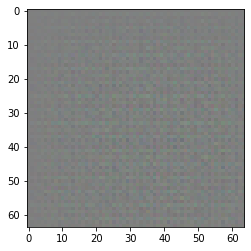

In [31]:
LATENT_DIM = 100

if IMAGE_SHAPE == (64,64,3):
    discriminator = define_discriminator64(n_attributes=N_ATTRIBUTES)
    generator = define_generator64(latent_dim=LATENT_DIM, n_attributes=N_ATTRIBUTES)
elif IMAGE_SHAPE == (218,178,3):
    discriminator = define_discriminator218(n_attributes=N_ATTRIBUTES)
    generator = define_generator218(latent_dim=LATENT_DIM, n_attributes=N_ATTRIBUTES)
 

if N_ATTRIBUTES !=0:
    gan = ACGAN(discriminator, generator, latent_dim=LATENT_DIM, n_attributes=N_ATTRIBUTES)
else:
    gan = GAN(discriminator, generator, latent_dim=LATENT_DIM)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=ADAM_LR_D, beta_1=ADAM_B1, beta_2 = ADAM_B2),
    g_optimizer=keras.optimizers.Adam(learning_rate=ADAM_LR_G, beta_1=ADAM_B1, beta_2 = ADAM_B2),
    loss_fn=keras.losses.BinaryCrossentropy()
)

# build model for saving

random_latent_vectors = tf.random.normal(shape=(1, LATENT_DIM))
if N_ATTRIBUTES !=0:
    random_attr = np.array([df[LABELS].values[i] for i in np.random.randint(0,202600, 1)])
    #random_attr = np.zeros((1,N_ATTRIBUTES))

    images, d_loss = gan.predict((random_latent_vectors, random_attr))

    plt.title('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*label for i,label in enumerate(random_attr[0])]))
else:
    images, d_loss = gan.predict(random_latent_vectors)

print(images.shape, np.min(images), np.max(images))
plt.imshow(images[0]/2+0.5)
#gan.save('models/'+model_name+experiment_name, save_format='tf')
resume_epoch = 0

In [28]:
if WANDB_RESUME:
    run_name = entity+'/GAN/'+ model_name + experiment_name
    artifact_run = run_name +':latest'

    artifact = run.use_artifact(artifact_run, type='model')
    artifact_dir = artifact.download()
    gan.load_weights(os.path.join(artifact_dir, model_name + experiment_name))
    resume_epoch = int(artifact_dir.split(':v')[-1]) +1
else:
    resume_epoch = 0

resume_epoch

0

## Train

In [ ]:
epochs = 60 

if ENABLE_WANDB:
    callbacks = [
        WandbCallback(log_batch_frequency=10, verbose=1),
        ImagesLogger(num_img=8, latent_dim=LATENT_DIM),
        ModelLogger(model_name+experiment_name, run=run)]

    if N_ATTRIBUTES !=0:
        callbacks.append(FIDLogger(real_embeddings, real_attr))
    else:
        callbacks.append(FIDLogger(real_embeddings))

history = gan.fit(dataset_train, epochs=epochs,
        initial_epoch=resume_epoch, 
        #steps_per_epoch=20,
        callbacks = callbacks
)


Epoch 1/60
 327/3166 [==>...........................] - ETA: 14:25 - d_loss: 0.1809 - g_loss: 4.5714